In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import random

class DataLoader():
    def __init__(self, filepath):
        cwd = os.getcwd()
        self.basepath = filepath
        try:
            os.stat(self.basepath+"/add_prim_split")
            os.stat(self.basepath+"/few_shot_split")
            os.stat(self.basepath+"/filler_split")
            os.stat(self.basepath+"/length_split")
            os.stat(self.basepath+"/simple_split")
            os.stat(self.basepath+"/template_split")
        except Exception as e:
            raise Exception("Path "+filepath+" doesnt seem to contain the required folders.")

    def load_1a(self):
        train = self.file_loader("/simple_split/tasks_train_simple.txt")
        test = self.file_loader("/simple_split/tasks_test_simple.txt")

        return (np.asarray(train), np.asarray(test))

    def load_1b(self):
        percentile_dict = {}
        splits = ["1", "2", "4", "8", "16", "32", "64"]

        for percentile in splits:
            train = self.file_loader("/simple_split/size_variations/tasks_train_simple_p{}.txt".format(percentile))
            test = self.file_loader("/simple_split/size_variations/tasks_test_simple_p{}.txt".format(percentile))
            
            percentile_dict[percentile] = (np.asarray(train), np.asarray(test))
            
        return percentile_dict

    def load_2(self):
        train = self.file_loader("/length_split/tasks_train_length.txt")
        test = self.file_loader("/length_split/tasks_test_length.txt")

        return (np.asarray(train), np.asarray(test))

    def load_3(self):
        """
        loads the datasets for both parts of the experiment
        the first part where both primitives appear without compositional commands
        the second part where 'jump' primitive appears in
        compositional commands of varying lengths
        returns a dictionary of pairs all possible train/test sets
        """
        data_dict = {}
        nums = ["1", "2", "4", "8", "16", "32"]
        reps = ["1", "2", "3", "4", "5"]

        train = self.file_loader("/add_prim_split/tasks_train_addprim_jump.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_jump.txt")
        data_dict['jump'] = (np.asarray(train), np.asarray(test))

        train = self.file_loader("/add_prim_split/tasks_train_addprim_turn_left.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_turn_left.txt")
        data_dict['lturn'] = (np.asarray(train), np.asarray(test))
        
        for num in nums:
            for rep in reps:
                train = self.file_loader("/add_prim_split/with_additional_examples/tasks_train_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                test = self.file_loader("/add_prim_split/with_additional_examples/tasks_test_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                
                data_dict['jump_num{}_rep{}'.format(num, rep)] = (np.asarray(train), np.asarray(test))
            
        return data_dict

    def file_loader(self, path):
        sent_list = []
        with open(self.basepath+path, "r") as f:
                    for line in f:
                        sent_list.append(line_splitter(line))
        return sent_list

    
def line_splitter(sentence):
    sent_list = sentence.split("OUT: ")
    sent_list[0] = sent_list[0].strip("IN: ")
    sent_list[1] = sent_list[1].strip("\n")

    return sent_list


In [0]:
#from data_loader import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SOS_token = 0
EOS_token = 1

class Input:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 2  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class Output:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        #self.index2word = {}
        self.n_words = 2  # Count SOS and EOS
        #self.n_words = 0

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


        
def get_embedding(word, lookup_dict, embeds):
    tensor = torch.tensor([lookup_dict[word]], dtype=torch.long)
    return embeds(tensor)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [0]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.0, layers=1, mode='RNN'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        output, hidden = self.hidden_layer(output, hidden)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.0, layers=1, attention=False, mode='RNN'):
    	#layers should be either 1 or 2
    	#in the latter case remember to pass a pair of hidden states!
    	#mode can be either 'LSTM', 'GRU' or 'RNN'
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        self.max_length = max_length
        self.attention = attention
        self.mode = mode

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        if self.attention:
	        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
	        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

        if mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        elif mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        if self.attention:
          attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0][0]), 1)), dim=1)   
          attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
          output = torch.cat((output[0], attn_applied[0]), 1)
          output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.hidden_layer(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden

def train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, clipping_value=5, mode='RNN'):
    encoder_hidden1 = encoder.initHidden()
    encoder_hidden2 = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        if mode == 'LSTM':
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei], (encoder_hidden1, encoder_hidden2))
        else: 
            encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden1 = encoder_hidden1
    decoder_hidden2 = encoder_hidden2

    forcing = random.random() > 0.5

    if forcing:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            decoder_input = output_tensor[di]
            loss += criterion(decoder_output, output_tensor[di])

            if decoder_input.item() == EOS_token:
                break
    else:
        for di in range(output_length):
            if mode == 'LSTM':
                decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
                decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, output_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break

    #loss = CustomLoss
    loss.backward()

    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping_value)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping_value)

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / output_length

    
def trainIters(encoder, decoder, train_data, input_lang, output_lang, max_length, learning_rate=0.001, mode='RNN'):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    losses = []
    print(train_data.shape[0])
    print_loss_total = 0

    for iter in range(1, train_data.shape[0]+1):
        training_pair = tensorsFromPair(train_data[iter-1], input_lang, output_lang)
        input_tensor = training_pair[0]
        output_tensor = training_pair[1]

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            output_tensor = output_tensor.cuda()
        
        loss = train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, mode=mode)
        print_loss_total += loss

        if iter % 500 == 0:
            print_loss_avg = print_loss_total / 500
            losses.append(print_loss_avg)
            print(iter)
            print(print_loss_avg)
            print_loss_total = 0

    return losses


dl = DataLoader("/content/drive/My Drive/SCAN")
#dl = DataLoader("SCAN")
train_data, test_data = dl.load_1a()

#MAX_LENGTH = max([len(x[0].split()) for x in train_data]) + 1
MAX_LENGTH = 100

train_in = Input("train_input")
train_out = Output("train_output")

test_in = Input("test_input")
test_out = Output("test_output")

for datapoint in train_data:
        train_in.addSentence(datapoint[0])
        train_out.addSentence(datapoint[1])

for datapoint in test_data:
        test_in.addSentence(datapoint[0])
        test_out.addSentence(datapoint[1])

In [5]:
print(MAX_LENGTH)

100


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

def train_and_save(train_data, model, dropout, att, layers, hid_size, model_name):
    encoder = Encoder(train_in.n_words, hid_size, layers=layers, mode=model, dropout_p=dropout)
    decoder = Decoder(hid_size, train_out.n_words, layers=layers, max_length=MAX_LENGTH, mode=model, dropout_p=dropout, attention=att)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    losses = trainIters(encoder, decoder, train_data, train_in, train_out, MAX_LENGTH, mode=model)
    plt.plot(losses)
    plt.title(model+'_layers='+str(layers)+'_drop='+str(dropout)+'_attention='+str(att))
    plt.xlabel('epochs (500 iters)')
    plt.ylabel('loss')
    plt.show()
    torch.save(encoder.state_dict(), "/content/drive/My Drive/"+model_name+"_encoder.pt")
    torch.save(decoder.state_dict(), "/content/drive/My Drive/"+model_name+"_decoder.pt")

In [0]:
model='LSTM'
train_and_save(model, 0.0, True, 2, 'lstm_best_model_new_run')
print("################### FIRST DONE ###################")
#train_and_save(model, 0.0, False, 2, 'lstm_no_att_no_drop_rerun')
print("################### SECOND DONE ###################")
#train_and_save(model, 0.0, True, 2, 'lstm_att_no_drop_rerun')
print("################### THIRD DONE ###################")

100000
0
0.004253089007209329
500
1.5181062831828962
1000
1.121401363202697
1500
0.8353661660461239
2000
0.6479775497313912
2500
0.540345323678586
3000
0.5019784387447097
3500
0.43180066251057747
4000
0.39561247857302234
4500
0.3255970626303541
5000
0.27799346791739027
5500
0.296971794848713
6000
0.20313256162008037
6500
0.19290872534450051
7000
0.19568008981633964
7500
0.17676952764546638
8000
0.1740573542565948
8500
0.15570554108918447
9000
0.1126060076944446
9500
0.08438909998282641
10000
0.08910418358039425
10500
0.07451056556369279
11000
0.08220850386700149
11500
0.060685938689363235
12000
0.07557218667156644
12500
0.09316911259045596
13000
0.07357679929194963
13500
0.06524292636122675
14000
0.07378296904410306
14500
0.04041570619745004
15000
0.0342918878519411
15500
0.047741123912442465
16000
0.042060391779788535
16500
0.06116929254132925
17000
0.051741530579498145
17500
0.03504162279995853
18000
0.030320404899531903
18500
0.024259546532717734
19000
0.026662314422284627
19500
0.0

In [0]:
encoder = Encoder(train_in.n_words, 200, layers=2, mode="LSTM", dropout_p=0.0)
encoder.load_state_dict(torch.load("/content/drive/My Drive/lstm_best_model_new_run_encoder.pt"))
encoder.eval()

decoder = Decoder(200, train_out.n_words, layers=2, max_length=MAX_LENGTH, mode="LSTM", dropout_p=0.0, attention=False)
decoder.load_state_dict(torch.load("/content/drive/My Drive/lstm_best_model_new_run_decoder.pt"))
decoder.eval()

Decoder(
  (embedding): Embedding(8, 200)
  (dropout): Dropout(p=0.0, inplace=False)
  (hidden_layer): LSTM(200, 200, num_layers=2)
  (out): Linear(in_features=200, out_features=8, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
import nltk
#BLEUscore = nltk.translate.bleu_score.sentence_bleu([], )
print(torch.cuda.is_available())

True


In [0]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from data_loader import *
#from embeddings import *
#from layers_attempt import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=100):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
        input_length = input_tensor.size()[0]
        encoder_hidden1 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)
        encoder_hidden2 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei],
                                                     (encoder_hidden1, encoder_hidden2))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden1 = encoder_hidden1
        decoder_hidden2 = encoder_hidden2

        decoded_words = []
        for di in range(max_length):
            decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        return decoded_words

def evaluateIters(test_data, encoder, decoder, lang_in, lang_out):
    hit = 0
    miss = 0
    iters = 0
    hit_idx = []
    miss_idx = []
    bleu_scores = []

    for idx, test_point in enumerate(test_data):
        pred_list = evaluate(encoder, decoder, test_point[0], lang_in, lang_out)
        pred = " ".join(pred_list)
        
        if pred == test_point[1]:
            hit += 1
            hit_idx.append(idx)
        else:
            miss += 1
            miss_idx.append(idx)
        iters += 1

    return hit, hit_idx, miss, miss_idx
#actual_train_data, _test_data = dl.load_1a()
#hit, hit_idx, miss, miss_idx, bleu_scores = evaluateIters(test_data, encoder, decoder, train_in, train_out, 8)

In [0]:
def train_and_eval(model, dropout, att, layers, hid_size, model_name, lang_in, lang_out):
    accs = []
    for i in range(1, 6):
        tr_data = train_data[np.random.choice(train_data.shape[0], 100000, replace=True), :]
        
        train_and_save(tr_data, model, dropout, att, layers, hid_size, model_name+str(i))

        encoder = Encoder(lang_in.n_words, hid_size, layers=layers, mode=model, dropout_p=dropout)
        encoder.load_state_dict(torch.load("/content/drive/My Drive/"+model_name+str(i)+"_encoder.pt"))

        decoder = Decoder(hid_size, lang_out.n_words, layers=layers, max_length=MAX_LENGTH, mode=model, dropout_p=dropout, attention=att)
        decoder.load_state_dict(torch.load("/content/drive/My Drive/"+model_name+str(i)+"_decoder.pt"))

        if torch.cuda.is_available():
            encoder.cuda()
            decoder.cuda()

        hit, hit_idx, miss, miss_idx = evaluateIters(test_data, encoder, decoder, lang_in, lang_out)

        print(1-miss/test_data.shape[0])
        accs.append(1-miss/test_data.shape[0])
    
    return accs


100000
500
1.5993382168621504
1000
1.2552075952351935
1500
1.0603007502963064
2000
0.9434716570249275
2500
0.8577714684385013
3000
0.7493206040957898
3500
0.6965172035279871
4000
0.6314446552239118
4500
0.598997226728561
5000
0.5411299665181393
5500
0.5186439993907677
6000
0.5010553972572687
6500
0.43546755566953466
7000
0.4684137372645387
7500
0.43194183240682565
8000
0.4348789080583423
8500
0.42690049765053817
9000
0.3770139216808899
9500
0.3757379981758457
10000
0.4026946473438776
10500
0.37677059567622945
11000
0.3597399687424889
11500
0.31933990590122857
12000
0.3314215812958761
12500
0.329195734682368
13000
0.2839778433754858
13500
0.30430868353153845
14000
0.30081223790376205
14500
0.31671649137478
15000
0.28153269251109925
15500
0.2729095853545137
16000
0.2942121161081165
16500
0.2745084362131504
17000
0.22807975373208206
17500
0.24134116606720635
18000
0.2676288153061067
18500
0.2133740730439704
19000
0.2549919533485857
19500
0.2382366120315529
20000
0.23517623100042337
20500


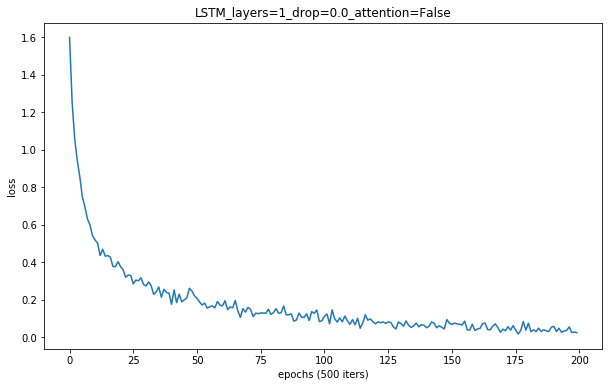

0.921090387374462
100000
500
1.6491264032848256
1000
1.2196507398608658
1500
1.0111278381561053
2000
0.9090928677810484
2500
0.825348803933774
3000
0.7415753338310251
3500
0.7064675444534663
4000
0.6822976054432107
4500
0.6392898397862237
5000
0.6017208877790928
5500
0.5517761071366546
6000
0.5261617699519687
6500
0.5400094695635785
7000
0.5058641360434285
7500
0.487243343941884
8000
0.45191954187321803
8500
0.46391152834623667
9000
0.43903477117080375
9500
0.39855668765090707
10000
0.3677421095389954
10500
0.4248085407881686
11000
0.3446520773148844
11500
0.36911032881075395
12000
0.3532883297926915
12500
0.33419202759224403
13000
0.35131399769626587
13500
0.33645328969716476
14000
0.30732085507415974
14500
0.3152772017931245
15000
0.3208780417973687
15500
0.3213222161607276
16000
0.26905539032120207
16500
0.2684893330437478
17000
0.24211772297213754
17500
0.2594206444882367
18000
0.28186946601461416
18500
0.22843797012123732
19000
0.24506020905118153
19500
0.19781508617570284
20000
0

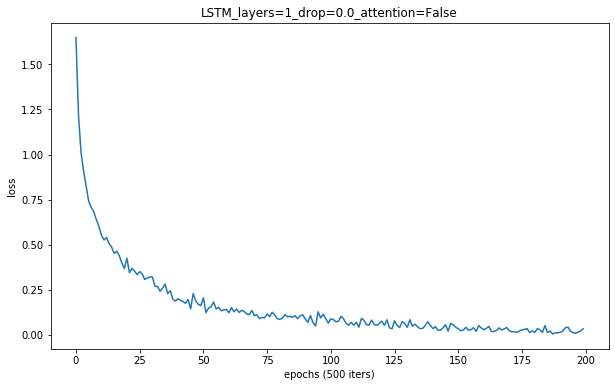

0.9624581539933046
100000
500
1.6436363474840576
1000
1.2358244544016175
1500
1.0444342972079261
2000
0.9279848567820306
2500
0.8128011576417
3000
0.7393804322553568
3500
0.6806383548386015
4000
0.6575138762594119
4500
0.5783954229862731
5000
0.5807087613032041
5500
0.5367535354228542
6000
0.5291269533079564
6500
0.5075793465033424
7000
0.4494124688920779
7500
0.45007073025931466
8000
0.4623077315660753
8500
0.4396519972716825
9000
0.3727266403941038
9500
0.411054840810968
10000
0.39120142413629294
10500
0.3768218235155911
11000
0.36333559028936874
11500
0.36394562324120067
12000
0.3628989514333696
12500
0.3421422457754554
13000
0.3487173556612565
13500
0.30472235806003134
14000
0.2915386952571233
14500
0.2678217849604538
15000
0.2751729472445845
15500
0.2888079619394285
16000
0.32432620341822166
16500
0.28280751037024177
17000
0.2403053452519674
17500
0.2416733036500643
18000
0.25068921250720194
18500
0.19727274903383507
19000
0.2160373969765994
19500
0.2276356413120204
20000
0.187297

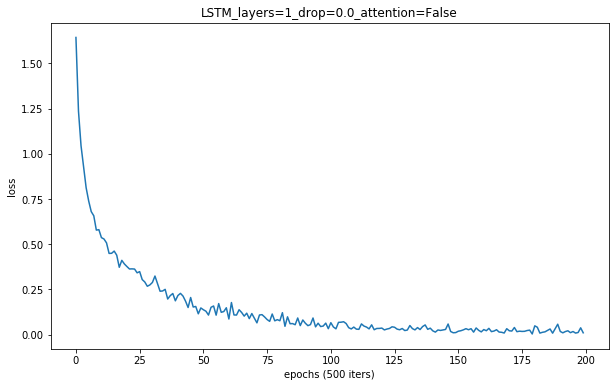

0.8187470109995217
100000
500
1.6425864686501388
1000
1.2940277789600025
1500
1.1021484406049957
2000
0.9882576991792197
2500
0.8270574823463192
3000
0.7994139557715657
3500
0.7215536303897476
4000
0.6608127503592323
4500
0.6346735227086836
5000
0.5478680532046095
5500
0.5493418233511272
6000
0.5093616744499574
6500
0.5089651127457637
7000
0.4705364907209037
7500
0.49570331858108546
8000
0.4213383020496783
8500
0.4485435848329994
9000
0.4149222710229656
9500
0.4480515648667725
10000
0.36307464401820494
10500
0.3944168569293888
11000
0.38152479991918925
11500
0.35272030595693815
12000
0.36537251166183343
12500
0.34708652684952385
13000
0.3132732966894712
13500
0.3526537234504282
14000
0.29208853303624943
14500
0.2645081905103774
15000
0.28822522198817024
15500
0.24303997243875866
16000
0.2989102980710006
16500
0.3088782190239273
17000
0.2928522535362864
17500
0.2519101564366464
18000
0.27652341128928826
18500
0.22178205227651865
19000
0.2731463986514402
19500
0.24992418861503207
20000
0

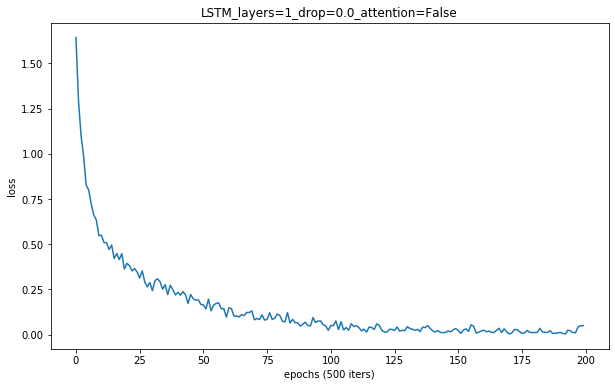

0.9218077474892397
100000
500
1.5827379438263618
1000
1.2520600703394609
1500
1.024642130549204
2000
0.8920904177468999
2500
0.8179701497630587
3000
0.7690561273501343
3500
0.741627585415129
4000
0.6799171623364287
4500
0.61202567989177
5000
0.6140207523262269
5500
0.5806072817231919
6000
0.5384903733877441
6500
0.4958282116110616
7000
0.47406401826947153
7500
0.5004347721358314
8000
0.44415207990886213
8500
0.4349323978316367
9000
0.37911771844202563
9500
0.3787709629090219
10000
0.37367627460390873
10500
0.33426972976699454
11000
0.3457756775722345
11500
0.3565270387761448
12000
0.3332108083910119
12500
0.32828848733363497
13000
0.26270239568444315
13500
0.29562781359452633
14000
0.3087100484806975
14500
0.27872602904670357
15000
0.25788437812652343
15500
0.2608697894384549
16000
0.27085230975322067
16500
0.2461319290628992
17000
0.25407909502394505
17500
0.26740038634011976
18000
0.21692475925788532
18500
0.2423865491254718
19000
0.18431295982897347
19500
0.1756812065292983
20000
0.

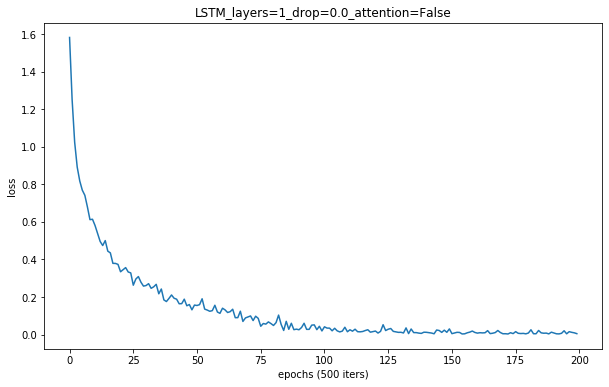

0.9813486370157819
[0.921090387374462, 0.9624581539933046, 0.8187470109995217, 0.9218077474892397, 0.9813486370157819]


0.921090387374462

In [9]:
model = 'LSTM'
res = train_and_eval(model, 0.0, False, 1, 50, 'lstm_att_no_drop1x50', train_in, train_out)
print(res)
np.mean(res)

In [0]:
bleu_scores[2213]

0.3303164318013807

In [0]:
1-miss/test_data.shape[0]

0.9232424677187948